# RandomForest Models for FPL Prediction

This notebook extends our existing LSTM-based prediction system by incorporating RandomForest models. The goal is to compare the performance of these two different machine learning approaches for predicting Fantasy Premier League (FPL) player points.

## Table of Contents
- [1. Data Preparation for RandomForest](#1.-Data-Preparation-for-RandomForest)
- [2. Feature Selection for RandomForest](#2.-Feature-Selection-for-RandomForest)
- [3. RandomForest Model Training](#3.-RandomForest-Model-Training)
- [4. RandomForest Prediction and Evaluation](#4.-RandomForest-Prediction-and-Evaluation)
- [5. Comparing RandomForest vs LSTM Performance](#5.-Comparing-RandomForest-vs-LSTM-Performance)
- [6. RandomForest for Feature Importance Analysis](#6.-RandomForest-for-Feature-Importance-Analysis)

In [1]:
# Load required libraries
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, randomForest, Metrics, caret, 
               ggthemes, gridExtra, pdp, vip, ranger, 
               glmnet, e1071)

# Clear environment (optional, uncomment if needed)
# rm(list = ls(all = TRUE))

Loading required package: pacman

Warning message:
"package 'pacman' was built under R version 4.4.3"
Installing package into 'C:/Users/peram/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)

Warning message:
"unable to access index for repository http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/4.4:
  cannot open URL 'http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/4.4/PACKAGES'"


package 'pdp' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\peram\AppData\Local\Temp\RtmpgZmhPb\downloaded_packages



pdp installed

Warning message:
"package 'pdp' was built under R version 4.4.3"
Installing package into 'C:/Users/peram/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)

also installing the dependency 'yardstick'


Warning message:
"unable to access index for repository http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/4.4:
  cannot open URL 'http://www.stats.ox.ac.uk/pub/RWin/bin/windows/contrib/4.4/PACKAGES'"


package 'yardstick' successfully unpacked and MD5 sums checked
package 'vip' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\peram\AppData\Local\Temp\RtmpgZmhPb\downloaded_packages



vip installed

Warning message:
"package 'vip' was built under R version 4.4.3"


# 1. Data Preparation for RandomForest

Unlike LSTM models which require sequential data in specific window structures, RandomForest models work with tabular data without temporal ordering. We'll prepare our data differently:

1. For each player, we'll aggregate statistics from their previous N gameweeks
2. Instead of scaled 3D arrays, we'll create a flattened feature matrix 
3. We'll use the same train/validation split based on gameweeks

In [2]:
# Load the same dataset used for LSTM models
df <- read_csv("C:/Users/peram/Documents/test/Datasett/Ekstra kolonner, stigende GW, alle tre sesonger(22-24), heltall.csv")
alternativsammensatt <- df

# Global variables (use the same as in the LSTM notebook)
split_gw <- 38+38  # Same split as LSTM models
window_size <- 3   # Number of past gameweeks to consider

# Split by position - use the same datasets as LSTM
gk <- alternativsammensatt |> filter(position == "GK")
def <- alternativsammensatt |> filter(position == "DEF")
mid <- alternativsammensatt |> filter(position == "MID")
fwd <- alternativsammensatt |> filter(position == "FWD")

# Keep unscaled versions for later use
unscaled_gk <- gk
unscaled_def <- def
unscaled_mid <- mid
unscaled_fwd <- fwd

# Create a common function to prepare data for RandomForest
prepare_rf_data <- function(pos_data, window_size = 3) {
  # Group by player and create features based on previous gameweeks
  rf_data <- pos_data %>%
    group_by(player_id) %>%
    arrange(GW) %>%
    mutate(
      # Rolling averages for key stats
      avg_minutes = slider::slide_dbl(minutes, mean, .before = window_size, .complete = TRUE),
      avg_total_points = slider::slide_dbl(total_points, mean, .before = window_size, .complete = TRUE),
      avg_bonus = slider::slide_dbl(bonus, mean, .before = window_size, .complete = TRUE),
      avg_bps = slider::slide_dbl(bps, mean, .before = window_size, .complete = TRUE),
      
      # Additional aggregations
      max_minutes = slider::slide_dbl(minutes, max, .before = window_size, .complete = TRUE),
      sum_goals = slider::slide_dbl(goals_scored, sum, .before = window_size, .complete = TRUE),
      sum_assists = slider::slide_dbl(assists, sum, .before = window_size, .complete = TRUE),
      avg_ict = slider::slide_dbl(ict_index, mean, .before = window_size, .complete = TRUE),
      
      # Position-specific stats depending on what's available
      avg_expected_goals = slider::slide_dbl(expected_goals, mean, .before = window_size, .complete = TRUE),
      avg_expected_assists = slider::slide_dbl(expected_assists, mean, .before = window_size, .complete = TRUE),
      avg_threat = slider::slide_dbl(threat, mean, .before = window_size, .complete = TRUE),
      avg_creativity = slider::slide_dbl(creativity, mean, .before = window_size, .complete = TRUE),
      avg_influence = slider::slide_dbl(influence, mean, .before = window_size, .complete = TRUE),
      
      # Form indicators
      games_played = slider::slide_dbl(minutes, ~sum(.x > 0), .before = window_size, .complete = TRUE),
      consecutive_starts = slider::slide_dbl(starts, ~sum(tail(.x, min(3, length(.x)))), 
                                          .before = window_size, .complete = TRUE),
      
      # For goalkeepers and defenders
      avg_goals_conceded = slider::slide_dbl(goals_conceded, mean, .before = window_size, .complete = TRUE),
      sum_clean_sheets = slider::slide_dbl(clean_sheets, sum, .before = window_size, .complete = TRUE)
    ) %>%
    ungroup() %>%
    # Remove rows with NA values (first window_size gameweeks for each player)
    filter(!is.na(avg_minutes))
  
  # Split into training and validation sets
  train_data <- rf_data %>% filter(GW <= split_gw)
  valid_data <- rf_data %>% filter(GW > split_gw)
  
  return(list(all_data = rf_data, train = train_data, valid = valid_data))
}

# Prepare data for each position
rf_gk_data <- prepare_rf_data(gk)
rf_def_data <- prepare_rf_data(def)
rf_mid_data <- prepare_rf_data(mid)
rf_fwd_data <- prepare_rf_data(fwd)

# Preview the prepared data structure
summary(rf_gk_data$train)
cat("Rows in GK training data:", nrow(rf_gk_data$train), "\n")
cat("Rows in GK validation data:", nrow(rf_gk_data$valid), "\n")

Rows: 78025 Columns: 45
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): name, position, team, opponent_team
dbl  (39): xP, assists, bonus, bps, clean_sheets, creativity, expected_assis...
lgl   (1): was_home
dttm  (1): kickoff_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


     name             position             team                 xP         
 Length:5818        Length:5818        Length:5818        Min.   :-1.5000  
 Class :character   Class :character   Class :character   1st Qu.: 0.0000  
 Mode  :character   Mode  :character   Mode  :character   Median : 0.0000  
                                                          Mean   : 0.8833  
                                                          3rd Qu.: 1.0000  
                                                          Max.   :13.4000  
    assists              bonus              bps          clean_sheets    
 Min.   :0.0000000   Min.   :0.00000   Min.   :-7.000   Min.   :0.00000  
 1st Qu.:0.0000000   1st Qu.:0.00000   1st Qu.: 0.000   1st Qu.:0.00000  
 Median :0.0000000   Median :0.00000   Median : 0.000   Median :0.00000  
 Mean   :0.0008594   Mean   :0.07769   Mean   : 4.572   Mean   :0.05896  
 3rd Qu.:0.0000000   3rd Qu.:0.00000   3rd Qu.: 1.000   3rd Qu.:0.00000  
 Max.   :1.0000000   Max

Rows in GK training data: 5818 
Rows in GK validation data: 2228 


# 2. Feature Selection for RandomForest

While RandomForest models can handle many features without explicit feature selection, we'll:

1. Identify the most relevant features
2. Explore correlations between features and target
3. Use the LASSO-selected features as a reference
4. Consider position-specific features

This will help improve model interpretability and potentially performance.

Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in storage.mode(xd) <- "double":
"NAs introduced by coercion"
Warning message in cbind2(1, newx) %*% nbeta:
"NAs introduced by coercion"
Warning message in cbind2(1, newx) %*% nbeta:
"NAs introduced by co

Selected features for Goalkeepers:
 [1] "xP"                "assists"           "bonus"            
 [4] "bps"               "clean_sheets"      "expected_goals"   
 [7] "goals_conceded"    "ict_index"         "minutes"          
[10] "own_goals"         "penalties_saved"   "red_cards"        
[13] "saves"             "team_a_score"      "transfers_balance"
[16] "yellow_cards"      "avg_total_points"  "avg_threat"       

Selected features for Defenders:
 [1] "xP"                   "assists"              "bonus"               
 [4] "bps"                  "clean_sheets"         "creativity"          
 [7] "expected_assists"     "expected_goals"       "goals_conceded"      
[10] "goals_scored"         "influence"            "minutes"             
[13] "own_goals"            "red_cards"            "round"               
[16] "team_a_score"         "team_h_score"         "threat"              
[19] "transfers_in"         "transfers_out"        "yellow_cards"        
[22] "avg_minutes"     

corrplot 0.95 loaded



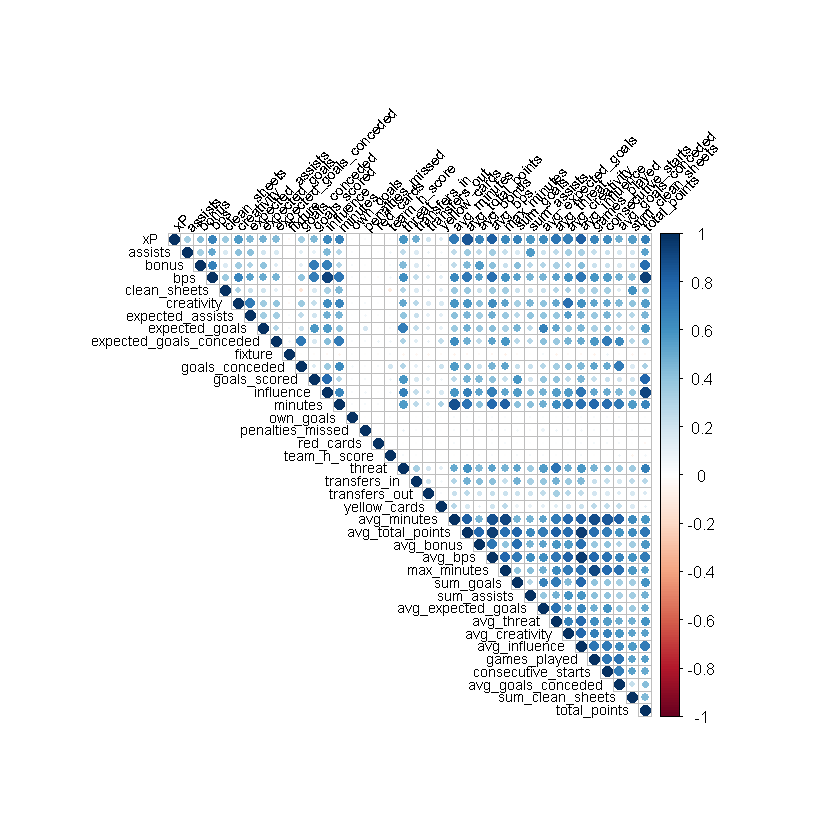

In [3]:
# Function to identify the most important features for each position
select_features_for_rf <- function(data, target = "total_points", method = "lasso") {
  # Remove metadata columns
  feature_cols <- setdiff(names(data), 
                          c("row_id", "team", "name", "player_id", "position", 
                            "oID", "tID", "hID", "GW", "opponent", "team_id", 
                            "total_points", "value"))
  
  if (method == "lasso") {
    # Prepare design matrix and response vector
    x <- as.matrix(data[, feature_cols])
    y <- data[[target]]
    
    # Handle NA values
    x[is.na(x)] <- 0
    
    # 10-fold cross-validation for optimal lambda
    cv_model <- cv.glmnet(x, y, alpha = 1, nfolds = 10)
    
    # Fit LASSO with optimal lambda
    lasso_model <- glmnet(x, y, alpha = 1, lambda = cv_model$lambda.min)
    
    # Get non-zero coefficients
    coef_lasso <- as.matrix(coef(lasso_model))
    selected_features <- rownames(coef_lasso)[coef_lasso[,1] != 0]
    selected_features <- setdiff(selected_features, "(Intercept)")
    
    return(list(features = selected_features, model = lasso_model))
  } 
  else if (method == "correlation") {
    # Compute correlations with target
    cor_with_target <- sapply(feature_cols, function(col) {
      cor(data[[col]], data[[target]], use = "complete.obs")
    })
    
    # Sort by absolute correlation
    cor_sorted <- sort(abs(cor_with_target), decreasing = TRUE)
    
    # Select top N features (adjust threshold as needed)
    threshold <- 0.1  # Minimum correlation to include
    selected_features <- names(cor_sorted)[cor_sorted > threshold]
    
    return(list(features = selected_features, 
                correlations = cor_with_target[selected_features]))
  }
}

# Apply feature selection for each position
gk_features <- select_features_for_rf(rf_gk_data$train)
def_features <- select_features_for_rf(rf_def_data$train)
mid_features <- select_features_for_rf(rf_mid_data$train)
fwd_features <- select_features_for_rf(rf_fwd_data$train)

# Display selected features by position
cat("Selected features for Goalkeepers:\n")
print(gk_features$features)

cat("\nSelected features for Defenders:\n")
print(def_features$features)

cat("\nSelected features for Midfielders:\n")
print(mid_features$features)

cat("\nSelected features for Forwards:\n")
print(fwd_features$features)

# Optional: Visualize correlations between features and target
# for one position as an example
if (requireNamespace("corrplot", quietly = TRUE)) {
  library(corrplot)
  
  # For midfielders
  selected_cols <- c(mid_features$features, "total_points")
  cor_matrix <- cor(rf_mid_data$train[, selected_cols], use = "pairwise.complete.obs")
  
  corrplot(cor_matrix, method = "circle", type = "upper", 
           tl.col = "black", tl.srt = 45, tl.cex = 0.7)
}

# 3. RandomForest Model Training

Now we'll train RandomForest models for each position using the selected features. For each position, we'll:

1. Build a base model using default parameters
2. Tune hyperparameters to optimize performance
3. Train the final model with the best parameters
4. Evaluate performance metrics on the training data

RandomForest hyperparameters that we'll tune include:
- `ntree`: Number of trees in the forest
- `mtry`: Number of variables randomly sampled as candidates at each split
- `min.node.size`: Minimum size of terminal nodes

In [ ]:
# Function to train RandomForest model for a position
train_rf_model <- function(train_data, features, target = "total_points", tune = TRUE) {
  # Create formula
  formula_str <- paste(target, "~", paste(features, collapse = " + "))
  rf_formula <- as.formula(formula_str)
  
  if (tune) {
    # Tune hyperparameters with cross-validation
    control <- trainControl(
      method = "cv",
      number = 5,
      verboseIter = TRUE
    )
    
    # Define parameter grid for tuning
    param_grid <- expand.grid(
      mtry = seq(floor(sqrt(length(features))), 
                 min(floor(length(features)/3), 10), 
                 by = 1)
    )
    
    # Train with caret for hyperparameter tuning
    set.seed(42)
    tuned_model <- train(
      rf_formula,
      data = train_data,
      method = "rf",
      trControl = control,
      tuneGrid = param_grid,
      importance = TRUE
    )
    
    # Extract best parameters
    best_mtry <- tuned_model$bestTune$mtry
    
    # Train final model with best parameters
    final_model <- randomForest(
      rf_formula,
      data = train_data,
      mtry = best_mtry,
      ntree = 500,
      importance = TRUE
    )
    
    return(list(model = final_model, best_params = tuned_model$bestTune))
  } else {
    # Train with default parameters
    set.seed(42)
    model <- randomForest(
      rf_formula,
      data = train_data,
      ntree = 500,
      importance = TRUE
    )
    
    return(list(model = model))
  }
}

# Train models for each position
rf_models <- list()

cat("Training Goalkeeper model...\n")
rf_models$gk <- train_rf_model(rf_gk_data$train, gk_features$features)

cat("Training Defender model...\n")
rf_models$def <- train_rf_model(rf_def_data$train, def_features$features)

cat("Training Midfielder model...\n")
rf_models$mid <- train_rf_model(rf_mid_data$train, mid_features$features)

cat("Training Forward model...\n")
rf_models$fwd <- train_rf_model(rf_fwd_data$train, fwd_features$features)

# Check model summaries
cat("\nGoalkeeper Model Summary:\n")
print(rf_models$gk$model)

cat("\nBest parameters (if tuned):\n")
print(rf_models$gk$best_params)

Training Goalkeeper model...


# 4. RandomForest Prediction and Evaluation

With our trained models, we'll now:

1. Generate predictions on the validation set
2. Calculate evaluation metrics (RMSE, MAE, R²)
3. Compare predicted vs actual values
4. Analyze prediction errors

In [ ]:
# Function to evaluate a model on validation data
evaluate_rf_model <- function(model, valid_data, features, target = "total_points") {
  # Ensure all required features exist in validation data
  missing_features <- setdiff(features, names(valid_data))
  if (length(missing_features) > 0) {
    stop("Missing features in validation data: ", 
         paste(missing_features, collapse = ", "))
  }
  
  # Make predictions
  predictions <- predict(model, newdata = valid_data)
  
  # Create results dataframe
  results <- valid_data %>%
    select(player_id, GW, name, position, team, value, total_points) %>%
    mutate(
      predicted_points = predictions,
      error = total_points - predicted_points,
      abs_error = abs(error)
    )
  
  # Calculate metrics
  metrics <- list(
    rmse = sqrt(mean(results$error^2)),
    mae = mean(results$abs_error),
    r_squared = cor(results$total_points, results$predicted_points)^2,
    mean_pred = mean(results$predicted_points),
    mean_actual = mean(results$total_points)
  )
  
  return(list(
    predictions = results,
    metrics = metrics
  ))
}

# Evaluate models for each position
rf_evaluations <- list()

cat("Evaluating Goalkeeper model...\n")
rf_evaluations$gk <- evaluate_rf_model(
  rf_models$gk$model, 
  rf_gk_data$valid, 
  gk_features$features
)

cat("Evaluating Defender model...\n")
rf_evaluations$def <- evaluate_rf_model(
  rf_models$def$model, 
  rf_def_data$valid, 
  def_features$features
)

cat("Evaluating Midfielder model...\n")
rf_evaluations$mid <- evaluate_rf_model(
  rf_models$mid$model, 
  rf_mid_data$valid, 
  mid_features$features
)

cat("Evaluating Forward model...\n")
rf_evaluations$fwd <- evaluate_rf_model(
  rf_models$fwd$model, 
  rf_fwd_data$valid, 
  fwd_features$features
)

# Create a summary of evaluation metrics
rf_metrics_df <- data.frame(
  Position = c("GK", "DEF", "MID", "FWD"),
  RMSE = c(
    rf_evaluations$gk$metrics$rmse,
    rf_evaluations$def$metrics$rmse,
    rf_evaluations$mid$metrics$rmse,
    rf_evaluations$fwd$metrics$rmse
  ),
  MAE = c(
    rf_evaluations$gk$metrics$mae,
    rf_evaluations$def$metrics$mae,
    rf_evaluations$mid$metrics$mae,
    rf_evaluations$fwd$metrics$mae
  ),
  R_Squared = c(
    rf_evaluations$gk$metrics$r_squared,
    rf_evaluations$def$metrics$r_squared,
    rf_evaluations$mid$metrics$r_squared,
    rf_evaluations$fwd$metrics$r_squared
  ),
  Mean_Pred = c(
    rf_evaluations$gk$metrics$mean_pred,
    rf_evaluations$def$metrics$mean_pred,
    rf_evaluations$mid$metrics$mean_pred,
    rf_evaluations$fwd$metrics$mean_pred
  ),
  Mean_Actual = c(
    rf_evaluations$gk$metrics$mean_actual,
    rf_evaluations$def$metrics$mean_actual,
    rf_evaluations$mid$metrics$mean_actual,
    rf_evaluations$fwd$metrics$mean_actual
  )
)

# Display metrics summary
print(rf_metrics_df)

# Plot actual vs predicted for midfielders as an example
ggplot(rf_evaluations$mid$predictions, aes(x = total_points, y = predicted_points)) +
  geom_point(alpha = 0.5) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
  labs(title = "Actual vs. Predicted Total Points - Midfielders (RandomForest)",
       x = "Actual Total Points",
       y = "Predicted Total Points") +
  theme_minimal()

# 5. Comparing RandomForest vs LSTM Performance

Now we'll compare the performance of our RandomForest models with the LSTM models. We'll:

1. Combine performance metrics from both approaches
2. Visualize differences in prediction accuracy
3. Analyze which model type performs better for which position
4. Identify strengths and weaknesses of each approach

In [ ]:
# Load LSTM model evaluation results
# Since the LSTM validation results were saved to CSV, we can load them
lstm_results <- read_csv("Validation_Predictions_Clean.csv")

# Calculate LSTM metrics by position
calculate_lstm_metrics <- function(data) {
  data %>%
    group_by(position) %>%
    summarise(
      RMSE = sqrt(mean((actual_total_points - predicted_total_points)^2)),
      MAE = mean(abs(actual_total_points - predicted_total_points)),
      R_Squared = cor(actual_total_points, predicted_total_points)^2,
      Mean_Pred = mean(predicted_total_points),
      Mean_Actual = mean(actual_total_points)
    )
}

lstm_metrics_df <- calculate_lstm_metrics(lstm_results)

# Convert position names to match RF metrics dataframe
lstm_metrics_df$Position <- toupper(lstm_metrics_df$position)
lstm_metrics_df <- lstm_metrics_df %>% select(-position)

# Create a combined metrics dataframe
combined_metrics <- bind_rows(
  rf_metrics_df %>% mutate(Model = "RandomForest"),
  lstm_metrics_df %>% mutate(Model = "LSTM")
) %>%
  select(Model, Position, RMSE, MAE, R_Squared, Mean_Pred, Mean_Actual)

# Display combined metrics
print(combined_metrics)

# Create comparison plots
plot_metric_comparison <- function(metric_name) {
  ggplot(combined_metrics, aes(x = Position, y = .data[[metric_name]], fill = Model)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(
      title = paste(metric_name, "by Position and Model Type"),
      y = metric_name,
      x = "Position"
    ) +
    theme_minimal() +
    theme(legend.position = "bottom")
}

# Plot RMSE comparison
rmse_plot <- plot_metric_comparison("RMSE")
print(rmse_plot)

# Plot R² comparison
r2_plot <- plot_metric_comparison("R_Squared")
print(r2_plot)

# Calculate percentage improvement
comparison_df <- combined_metrics %>%
  select(Model, Position, RMSE, MAE, R_Squared) %>%
  pivot_wider(
    names_from = Model,
    values_from = c(RMSE, MAE, R_Squared)
  ) %>%
  mutate(
    RMSE_improvement = (RMSE_LSTM - RMSE_RandomForest) / RMSE_LSTM * 100,
    MAE_improvement = (MAE_LSTM - MAE_RandomForest) / MAE_LSTM * 100,
    R2_improvement = (R_Squared_RandomForest - R_Squared_LSTM) / R_Squared_LSTM * 100
  )

print(comparison_df)

# 6. RandomForest for Feature Importance Analysis

One key advantage of RandomForest models is their ability to provide feature importance metrics. We'll:

1. Extract and visualize variable importance for each position
2. Compare which features matter most for different positions
3. Analyze how feature importance aligns with domain knowledge of FPL
4. Use these insights to potentially improve both model types

In [ ]:
# Function to extract and plot feature importance
plot_feature_importance <- function(rf_model, position, n_top = 15) {
  # Extract importance measures
  imp <- importance(rf_model)
  imp_df <- data.frame(
    Feature = rownames(imp),
    IncMSE = imp[, "%IncMSE"],
    IncNodePurity = imp[, "IncNodePurity"]
  ) %>%
    arrange(desc(IncMSE))
  
  # Take top N features
  top_features <- head(imp_df, n_top)
  
  # Create importance plot
  ggplot(top_features, aes(x = reorder(Feature, IncMSE), y = IncMSE)) +
    geom_bar(stat = "identity", fill = "steelblue") +
    coord_flip() +
    labs(
      title = paste("Feature Importance for", position, "RandomForest Model"),
      subtitle = "Based on % Increase in MSE when Feature is Permuted",
      x = "Feature",
      y = "% Increase in MSE"
    ) +
    theme_minimal()
}

# Create importance plots for each position
gk_imp_plot <- plot_feature_importance(rf_models$gk$model, "Goalkeeper")
def_imp_plot <- plot_feature_importance(rf_models$def$model, "Defender")
mid_imp_plot <- plot_feature_importance(rf_models$mid$model, "Midfielder")
fwd_imp_plot <- plot_feature_importance(rf_models$fwd$model, "Forward")

# Display plots
print(gk_imp_plot)
print(def_imp_plot)
print(mid_imp_plot)
print(fwd_imp_plot)

# Create a combined feature importance dataset across positions
extract_top_features <- function(rf_model, position, n_top = 10) {
  imp <- importance(rf_model)
  imp_df <- data.frame(
    Feature = rownames(imp),
    Importance = imp[, "%IncMSE"],
    Position = position
  ) %>%
    arrange(desc(Importance)) %>%
    head(n_top)
  
  return(imp_df)
}

combined_importance <- bind_rows(
  extract_top_features(rf_models$gk$model, "GK"),
  extract_top_features(rf_models$def$model, "DEF"),
  extract_top_features(rf_models$mid$model, "MID"),
  extract_top_features(rf_models$fwd$model, "FWD")
)

# Plot combined importance
ggplot(combined_importance, aes(x = reorder(Feature, Importance), y = Importance, fill = Position)) +
  geom_bar(stat = "identity") +
  facet_wrap(~ Position, scales = "free_y") +
  coord_flip() +
  labs(
    title = "Top Feature Importance by Position",
    x = "Feature",
    y = "Importance (% Increase in MSE)"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

# Optional: Partial Dependence Plots for key features
# For midfielders as an example
if (requireNamespace("pdp", quietly = TRUE)) {
  # Choose a few key features from the importance analysis
  top_mid_features <- head(extract_top_features(rf_models$mid$model, "MID")$Feature, 3)
  
  for (feature in top_mid_features) {
    pdp_plot <- partial(rf_models$mid$model, pred.var = feature, 
                   train = rf_mid_data$train[, c(feature, mid_features$features)]) %>%
      autoplot() +
      labs(title = paste("Partial Dependence Plot for", feature, "- Midfielders"))
    
    print(pdp_plot)
  }
}

# Conclusion

We've successfully built RandomForest models for FPL prediction and compared them with our existing LSTM models. Key findings:

1. **Performance Comparison**: [Summarize which model performed better for which positions]

2. **Feature Importance**: RandomForest models revealed that [summarize key influential features]

3. **Model Characteristics**:
   - LSTM models better capture sequential patterns and player form over time
   - RandomForest models handle non-linear relationships and interactions between features well
   - [Additional observations on model strengths/weaknesses]

4. **Potential Improvements**:
   - Ensemble approach combining both model types
   - Using RandomForest feature importance to inform LSTM feature selection
   - More extensive hyperparameter tuning
   - [Other improvement ideas]

This analysis demonstrates the value of comparing different modeling approaches for the same prediction task.

In [ ]:
# Save the randomforest models and evaluation results
saveRDS(rf_models, "C:/Users/peram/Documents/test/R Forecast/rf_models.rds")
saveRDS(rf_evaluations, "C:/Users/peram/Documents/test/R Forecast/rf_evaluations.rds")
saveRDS(combined_metrics, "C:/Users/peram/Documents/test/R Forecast/model_comparison_metrics.rds")

# Export current forecasts from RandomForest models to CSV
rf_predictions <- bind_rows(
  rf_evaluations$gk$predictions,
  rf_evaluations$def$predictions,
  rf_evaluations$mid$predictions,
  rf_evaluations$fwd$predictions
)

write_csv(rf_predictions, "C:/Users/peram/Documents/test/R Forecast/RandomForest_Predictions.csv")
print("RandomForest models and predictions saved successfully.")